# Twitter Named Entity Recognition



## Problem Statement

Twitter is a microblogging and social networking service on which users post and interact with messages known as "tweets". Every second, on average, around 6,000 tweets are tweeted on Twitter, corresponding to over 350,000 tweets sent per minute, 500 million tweets per day.

Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. Many users do not use hashtags or sometimes use wrong or mis-spelled tags, so they want to completely remove this problem and create a system of recognizing important content of the tweets.

Named Entity Recognition (NER) is an important subtask of information extraction that seeks to locate and recognise named entities.

You need to train models that will be able to identify the various named entities.

## Data Description

Dataset is annotated with 10 fine-grained NER categories: person, geo-location, company, facility, product,music artist, movie, sports team, tv show and other. Dataset was extracted from tweets and is structured in CoNLL format., in English language. Containing in Text file format.


# Solution approach

In this notebook, I use char-CNN + Bidrectional LSTM + CRF architecture to solve NER problem for the given set of 6000 tweets. The tweets and named entities are provided in Conll format where each line contains a word and its BIO tag. The end of the sentence is represented with a blank line. There are total 21 BIO classes: B and I pair for 10 named entities and an 'O' class.

**Architecture summary**: Each sentence is padded to the length of 39 words. Each word is then converted to word embeddings. For each word, character level feature vector is computed and is concatenated with the word embeddings. The combined embeddings then pass through two stacked bi-directional LSTM layers, followed by a CRF layer. The CRF layer outputs both Viterbi decoding and potentials. Two models are created. First model computes predicition vector by  using Viterbi decoding. The second model computes prediction vector by simply taking argmax over the computed softmax probabilities. Both models are evaluated for comparision.

**Word embeddings**: I use gensim's 'glove-twitter-100' embedding in this case study. (I experimented with glove-twitter-50, glove-twitter-100, and word2vec-google-news-300 embeddings, and found 'glove-twitter-100' to perform reasonably well).

**Data imbalance**: The data is highly imbalanced with 'O' tag constituting around 92% of the words. To alleviate the data imbalance issue, I implementd the following measures.

  1. Undersampled majority class 'O' by removing 80% of the all-'O' statements. Over-sampled each entity class to ensure there are minimum 1000 examples of each class in the training set. With this the data imbalanced improved somewhat.  
  2. I used CategoricalFocalCrossEntropy function as a loss function which works better than plain CategoricalCrossEntropy function when the classes are highly imbalanced. I tuned Gamma(5), label-smoothing(0.15) and alpha (class weights) parameters to obtained better results.

**Custom metric**: I use Seqeval's f1 score as the primary evaluation metric which is suited for NER task evaluation. I also compute custom metrics such as balanced_accuracy (since the dataset is highly imbalanced, I avoid using accuracy) and weighted f1 score for entity classes (ignoring the majority 'O' class). The above metrics are implemented as Keras custom metrics so that they can be computed during the training loop. During evaluation, I compute both class level metrics (precision, recall, and standard F1 scores) as well as overall metrics (seqeval f1 score, balanced_accuracy, and weighted precision, recall, and F1 scores after ignoring the majority negative class 'O').

**Custom Features**: I add two types of custom features in the model
  1. I created a WordShapeLayer to compute word-shapes in short form and provide it as an additional custom feature to the dense layer. The word shape for a given word is computed as follow. Convert each upper-case letter to 'X', lower-case letter to 'x', digit to 'd', and keep the remaining letters of the word as is. I then decode each processed letter (X, x, d etc) to its ascii value to form its word shape vector. controlled by flags ('wordshape_classes_flag' and 'wordshape_classes')

  2. I created character embeddings matrix and used a set of conv1D and maxpooling operations to compute character level features (size 20) for each word. I then concatenated this feature with the word embeddings before passing it on the bi-directional LSTM layer (Flag: 'use_char_cnn')

  However, after trying a lot of combinations, I found these features to be redundant and often degrading the performance somewhat.

**Output class for padded tokens**: I explored two approaches of setting output class (in y_true) for the padded tokens.
  1. Simply set each padded token with 'O' class (i.e 0). When evaluating the metrics, ensure that padded words are ignored. However, the loss function still 'learns' on the padded tokens.
  2. Since we use CategoricalFocalCrossEntropy function as the loss function, it accpets y_true in one-hot-encoded form. For padded tokens, we simply set zero vector (all 21 numbers are set to zero). This ensures that loss function doesn't learn on the padded tokens. During evaluation, ensure that padded words are ignored.

  While the second approach seems more logical, counter intuitively, I got better results with the first approach. (Flag: 'use_tag_o_as_padding').

**output decoding**: The model's last layer is CRF. There are two ways to get output sequence (of tags) from the CRF layer. First, using Viterbi decoding, and second by simply taking argmax over the potentials returned by CRF. In this case study, I compute and evaluate outputs using both the approaches. Somewhat conter-intuitively, I found the second approach (taking argmax over the potentials) to work slightly better than the first approach of using Viterbi decoding.


# Solution

## Common installs

In [114]:
#mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
#load tensorflow_addons for CRF
!pip install tensorflow_addons

In [116]:
#mlflow for experiment tracking
!pip install mlflow --quiet

In [117]:
#evaluation metric
!pip install seqeval --quiet

In [118]:
#Common imports and constants
import numpy as np
import pandas as pd
import os.path
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

import tensorflow as tf
from keras.layers import TextVectorization, Embedding
from keras.utils import pad_sequences, to_categorical

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

import gensim.downloader as api
import random
import mlflow

tf.random.set_seed(123)

CONST = {
  'TRAIN_DATA_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/wnut 16.txt.conll',
  'DEV_DATA_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/wnut16_dev.conll',
  'TEST_DATA_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/wnut 16test.txt.conll',

  'SAVED_EMBED_MAT_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/saved_embed_mat/',
  'SAVED_EMBEDDINGS_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/gensim_embeddings/',
  'MLRUNS_PATH': '/content/drive/MyDrive/Scaler-case-studies/Twitter-NER/data/mlruns/',
  'MLFLOW_NER_CRF_EXPERIMENT_NAME' : 'mlflow_cef_exp',
  'MODEL_CHECKPOINT_FILE_PATH' : '/content/checkpoints/'
}

DATA_PARAMS = {
  'use_tag_o_as_padding': True,
  'preserve_case': False,
  'clean-url': True,
  'remove-special-chars': True,
  'embeddings': ['glove-twitter-100', 100],
  #'embeddings': ['word2vec-google-news-300', 300],
  'wordshape_classes': 15,
  'tr-test-split': 0.8,
  'all-o-keep-rate': 0.2,
  'oversample-min-cnt': 1000
}

#set random seed

def set_seeds(seed=123):
  os.environ['PYTHONHASHSEED']=str(seed)
  np.random.seed(1)
  tf.random.set_seed(seed)
  random.seed(seed)

set_seeds()

In [119]:
#create necessary directory structure locally and or on the mounted drive
if not os.path.exists(CONST['SAVED_EMBEDDINGS_PATH']):
    os.makedirs(CONST['SAVED_EMBEDDINGS_PATH'])

if not os.path.exists(CONST['SAVED_EMBED_MAT_PATH']):
    os.makedirs(CONST['SAVED_EMBED_MAT_PATH'])

if not os.path.exists(CONST['MLRUNS_PATH']):
    os.makedirs(CONST['MLRUNS_PATH'])

if not os.path.exists(CONST['MODEL_CHECKPOINT_FILE_PATH']):
    os.makedirs(CONST['MODEL_CHECKPOINT_FILE_PATH'])

In [120]:
# get or create crf experiment
mlflow.set_tracking_uri(f"file://{CONST['MLRUNS_PATH']}")

crf_exp_name = CONST['MLFLOW_NER_CRF_EXPERIMENT_NAME']
crf_exp = mlflow.get_experiment_by_name(crf_exp_name)
if(not crf_exp):
  crf_exp_id = mlflow.create_experiment(crf_exp_name)
else:
  crf_exp_id = crf_exp.experiment_id
print(crf_exp_id)


666199567224869247


In [121]:
#mlflow log
import json

class mlflow_logger:
  def __init__(self, mlflow):
    self.mlflow = mlflow

  def log_obj(self, obj):
    for k, v in obj.items():
      self.mlflow.log_param(k, v)

  def log_metric(self, k, v):
    mlflow.log_metric(k, v)

  def log_df_metrics(self, df):
    acc = df.loc[('-', 'accuracy', 'all (BIO)')][0]
    f1 = df.loc[('weighted', 'f1', 'all (BIO)')][0]
    f1_without_o = df.loc[('weighted', 'f1', 'only BI')][0]

    mlflow.log_metric('acc', acc)
    mlflow.log_metric('f1', f1)
    mlflow.log_metric('f1-without-o', f1_without_o)


In [122]:
#!rm -r '/content/mlruns'

## Load Data

In [123]:
# helper function to load conll file
def load_conll2(files, data_proc_fn=None):
  files = [files] if (type(files) == str) else files

  sentences = []
  words, words_orig_case, tags = [], [], []
  parse_err_cnt = 0

  for file in files:
    with open(file, "r") as f:

      while True:
        s = f.readline()
        if len(s) == 0: #end of file
          break

        s = s.strip()

        if not s: #end of sentence
          sentences.append((words, words_orig_case, tags))
          words, words_orig_case, tags = [], [], []
        else:
          #used defined pre-processing
          if(data_proc_fn):
            s = data_proc_fn(s)

          #parse
          try:
            word, tag = s.replace('\n', '').split('\t')
            word = word.strip()
            words_orig_case.append(word) #original case preserved

            if(not DATA_PARAMS['preserve_case']):
              word = word.lower()

            words.append(word) #converted to lower case
            tags.append(tag)

          except Exception as e:
            parse_err_cnt += 1
            print(f'error parsing {s}', e)
            break

      if(parse_err_cnt > 0):
        print(f'total parsing errors: {parse_err_cnt}')

  return sentences

def compute_data_objects(data):
  wordctr, tagctr = Counter(),Counter()
  word_tag_map, tag_word_map = defaultdict(), defaultdict()

  for i in range(len(data)):
    words_arr, tags_arr = data[i][0], data[i][2]
    wordctr.update(words_arr)
    tagctr.update(tags_arr)

    for j in range(len(words_arr)):
      word, tag = words_arr[j], tags_arr[j]

      #extract named entity name
      ne = tag.replace('B-', '').replace('I-', '')

      #add to word_tag_map
      if word not in word_tag_map.keys():
        word_tag_map[word] = set([ne])
      else:
        word_tag_map[word].add(ne)

      #add to tag_word_map
      if ne not in tag_word_map.keys():
        tag_word_map[ne] = set([word])
      else:
        tag_word_map[ne].add(word)

  return wordctr, tagctr, word_tag_map, tag_word_map

In [124]:
#merge train, dev and test data
merged_data = load_conll2([CONST['TRAIN_DATA_PATH'], CONST['DEV_DATA_PATH'], CONST['TEST_DATA_PATH']])

#split merged data into train and test sets
train_data, test_data = train_test_split(merged_data, test_size=0.25, random_state=42, shuffle=True)
train_data, dev_data = train_test_split(train_data, test_size=0.3, random_state=42, shuffle=True)

In [125]:
# #merge train, dev
# merged_data = load_conll2([CONST['TRAIN_DATA_PATH'], CONST['DEV_DATA_PATH']])

# #split merged data into train and test sets
# train_data, dev_data = train_test_split(merged_data, test_size=0.3, random_state=42, shuffle=True)
# test_data = load_conll2([CONST['TEST_DATA_PATH']])

In [126]:
# train_data = load_conll2([CONST['TRAIN_DATA_PATH']])
# test_data = load_conll2([CONST['TEST_DATA_PATH']])
# dev_data = load_conll2([CONST['DEV_DATA_PATH']])

In [127]:
#compute useful data objects
train_wordset, train_tagset, train_word_tag_map, train_tag_word_map = compute_data_objects(train_data)
test_wordset, test_tagset, test_word_tag_map, test_tag_word_map = compute_data_objects(test_data)
dev_wordset, dev_tagset, dev_word_tag_map, dev_tag_word_map = compute_data_objects(dev_data)

In [128]:
def get_sentences_and_tags(data):
  sentences = [words for words, words_orig_case, tags in data]
  sentences_orig_case = [words_orig_case for words, words_orig_case, tags in data]
  tags = [tags for words, words_orig_case, tags in data]

  return sentences, sentences_orig_case, tags

train_sentences, train_sentences_origcase, train_tags = get_sentences_and_tags(train_data)
test_sentences, test_sentences_origcase, test_tags = get_sentences_and_tags(test_data)
dev_sentences, dev_sentences_origcase, dev_tags = get_sentences_and_tags(dev_data)

## Data Exploration

In [129]:
print(f'No of training tweets: {len(train_data)}')
print(f'No of test tweets: {len(test_data)}')

max_train_seq_len = max([len(s[0]) for s in train_data])
max_test_seq_len = max([len(s[0]) for s in test_data])

print('Maximum words tweet in the training corpus:', max_train_seq_len)
print('Maximum words tweet in the test corpus:', max_test_seq_len)

print('unique words in the training corpus: ', len(train_wordset))
print('unique words in the test corpus: ', len(test_wordset))

print('unique tags in the training corpus:', len(train_tagset))
print('unique tags in the test corpus:', len(test_tagset))

MAX_LEN = max(max_train_seq_len, max_test_seq_len)

No of training tweets: 3801
No of test tweets: 1811
Maximum words tweet in the training corpus: 39
Maximum words tweet in the test corpus: 38
unique words in the training corpus:  15384
unique words in the test corpus:  8762
unique tags in the training corpus: 21
unique tags in the test corpus: 21


In [130]:
#check word-co frequency distribution
word_cnt_df = pd.DataFrame(train_wordset.items(), columns=['word', 'freq'])
word_cnt_freq_stats = word_cnt_df.groupby('freq').count().reset_index()

word_cnt_freq_stats

,freq,word
0,1,11393
1,2,1585
2,3,631
3,4,382
4,5,204
...,...,...
149,979,1
150,1290,1
151,1416,1
152,1558,1


In [131]:
def get_tags_count_df(tags_list):
  df = pd.Series(np.hstack(train_tags)).value_counts().to_frame()
  df = df.rename(columns={'count':'freq'})
  df['perc'] = np.round((df['freq'] / np.sum(df['freq'])) * 100, 3)
  return df

print('\ntag count distribution for training data\n')
print(get_tags_count_df(train_tags))

print('\ntag count distribution for dev data\n')
print(get_tags_count_df(dev_tags))

print('\ntag count distribution for test data\n')
print(get_tags_count_df(test_tags))


tag count distribution for training data

                freq    perc
O              60253  92.319
B-geo-loc        697   1.068
B-person         593   0.909
I-other          567   0.869
B-other          524   0.803
B-company        427   0.654
I-person         338   0.518
I-product        328   0.503
I-facility       264   0.404
B-facility       203   0.311
B-product        193   0.296
I-company        151   0.231
I-geo-loc        150   0.230
B-musicartist    134   0.205
I-musicartist    132   0.202
B-sportsteam     107   0.164
I-movie           51   0.078
B-movie           43   0.066
B-tvshow          41   0.063
I-tvshow          41   0.063
I-sportsteam      29   0.044

tag count distribution for dev data

                freq    perc
O              60253  92.319
B-geo-loc        697   1.068
B-person         593   0.909
I-other          567   0.869
B-other          524   0.803
B-company        427   0.654
I-person         338   0.518
I-product        328   0.503
I-facility       264

In [132]:
# check ratio of sentences with atleast one BI tag to total number of sentences
def ratio_of_tagged_sentences(tags_list):
  total_sentences = len(tags_list)
  tagged_sentences = np.sum([np.sum(np.array(sent) == 'O') == len(sent) for sent in tags_list])

  return np.round(100 * tagged_sentences / total_sentences, 2)

print('Training set: Percentage of sentences with named entities: ', ratio_of_tagged_sentences(train_tags), '%')
print('Test set: Percentage of sentences with named entities: ', ratio_of_tagged_sentences(test_tags), '%')

Training set: Percentage of sentences with named entities:  53.49 %
Test set: Percentage of sentences with named entities:  53.62 %


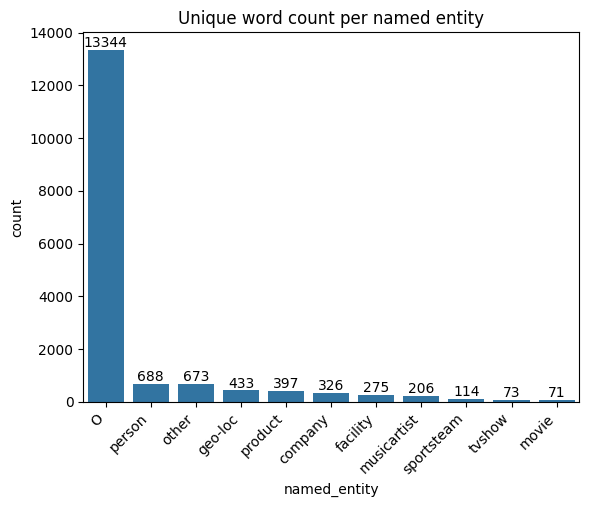

In [133]:
#check training named entities (after removing BIO prefixes)
ne_counts = pd.DataFrame([[tag, len(words)] for tag, words in train_tag_word_map.items()], columns=['named_entity', 'count'])
ne_counts = ne_counts.sort_values(by='count', ascending=False)

def makebarplot(x, y, title, rotateby=None):
  ax = sns.barplot(x=x, y=y)
  ax.bar_label(ax.containers[0])
  ax.set_title(title)
  if(rotateby):
    plt.xticks(rotation=rotateby, ha='right')
  plt.show()

makebarplot(ne_counts['named_entity'], ne_counts['count'], 'Unique word count per named entity', rotateby=45)

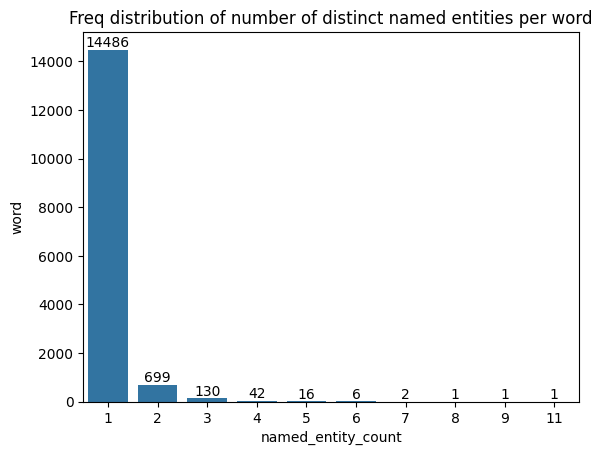

In [134]:
#frequency distribution of number of named entities per word (including 'O')
word_ne_counts = pd.DataFrame([[word, len(tags)] for word, tags in train_word_tag_map.items()], columns=['word', 'named_entity_count'])
word_ne_counts = word_ne_counts.groupby('named_entity_count').count().reset_index()

makebarplot(word_ne_counts['named_entity_count'], word_ne_counts['word'], 'Freq distribution of number of distinct named entities per word')

['12', '"', '3pcs', 'set', 'disney', 'frozen', 'queenx', 'elsa', 'princesses', 'anna', 'olaf', 'snowman', 'dolls', 'toys', '$', '5.50', '(', '6', 'bids)end', 'date', ':', 'friday', '...', 'http://t.co/lktxkmolgp'] O product
['saturday', 'night', 'live', '-', 'the', 'complete', 'first', 'season', ':', '1975-1976', 'dvd', ',', 'dan', 'aykroyd', ',', 'ch', 'http://t.co/oioi0whq8h', 'http://t.co/52uxc9mjcb'] O product
['sun', 'soccercard', 'no', '078', '-', 'west', 'brom', 'albion', 'man', 'city', 'asa', 'hartford', 'football', 'card', 'http://t.co/o9b3rx88sb', 'http://t.co/7f4vfowfds'] O product


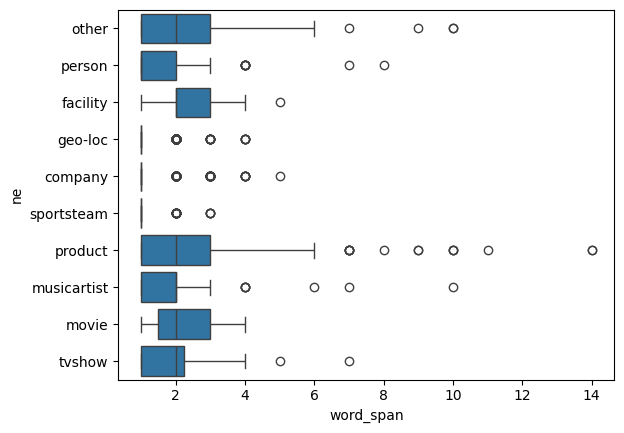

,word_span
ne,
company,1.35782
facility,2.29
geo-loc,1.216691
movie,2.186047
musicartist,1.969231
other,2.086873
person,1.567241
product,2.708333
sportsteam,1.257143


In [135]:
#distribution of span of named entities

tag_span_map = {}
for words, words_orig, tags in train_data:
  wordcnt = 0
  prev_ne = ''
  for tag in tags:

    if(tag.startswith('I-')):
      wordcnt += 1
    else:
      #add prev entity's word count
      if(wordcnt > 0):
        if(wordcnt > 10):
          print(words, tag, prev_ne)
        if(prev_ne not in tag_span_map.keys()):
          tag_span_map[prev_ne] = []

        tag_span_map[prev_ne].append(wordcnt)

      if tag.startswith('B-'):
        wordcnt = 1 #start new count for the new entity
        prev_ne = tag.replace('B-', '').replace('I-', '')
      else:
        wordcnt = 0 #skip this word ('O')
        prev_ne = ''
        continue

tag_span_df = pd.DataFrame(tag_span_map.items(), columns=['ne', 'word_span']).explode('word_span')
sns.boxplot(data=tag_span_df, x = 'word_span', y='ne')
plt.show()

tag_span_df.groupby('ne').mean().round(2)

## Data cleaning

In [136]:
#replace URLs with <URL> to avoid creating several vocabulary words unnecessarily
import re

url_pattern = re.compile(r'https?://(www.)?([^/?]*)(\S*)|www.([^/?]*)(\S*)',re.IGNORECASE)

def sanitize_sentences(data, clean_url=True, remove_special_char=True):

  cnt_url, cnt_sc = 0, 0

  if(not clean_url and not remove_special_char):
    return cnt_url, cnt_sc

  for i in range(len(data)):
    words, words_origcase = data[i][0], data[i][1]

    for j in range(len(words)):

      if(clean_url):

        res = re.match(url_pattern, words_origcase[j])
        if(res):
          words_origcase[j] = res.groups()[1] or res.groups()[3] or words_origcase[j]
          words[j] = words_origcase[j].lower()
          cnt_url += 1
          continue

      if(remove_special_char):
        newval = ''.join(e for e in words_origcase[j] if e.isalnum())
        if(newval != words_origcase[j]):
          #do not change words_origcase - we use it for char embedding
          words[j] = (newval or '#').lower()
          cnt_sc += 1

  return cnt_url, cnt_sc

clean_url_flag, remove_sp_char_flag = DATA_PARAMS['clean-url'], DATA_PARAMS['remove-special-chars']

tr_urls_cleaned, tr_special_char_removed = sanitize_sentences(train_data, clean_url_flag , remove_sp_char_flag)
dv_urls_cleaned, dv_special_char_removed = sanitize_sentences(dev_data, clean_url_flag, remove_sp_char_flag)
te_urls_cleaned, te_special_char_removed = sanitize_sentences(test_data, clean_url_flag, remove_sp_char_flag)

print(f'Train: url_cleaned: {tr_urls_cleaned}, special_chars removed: {tr_special_char_removed}')
print(f'Test: url_cleaned: {te_urls_cleaned}, special_chars removed: {te_special_char_removed}')
print(f'dev: url_cleaned: {dv_urls_cleaned}, special_chars removed: {dv_special_char_removed}')

Train: url_cleaned: 1759, special_chars removed: 14783
Test: url_cleaned: 786, special_chars removed: 6948
dev: url_cleaned: 740, special_chars removed: 6353


In [137]:
len(train_sentences), len(train_sentences_origcase), len(test_sentences), len(dev_sentences)

(3801, 3801, 1811, 1630)

## Word length distribution

4.303910152299819 4.0 10.0


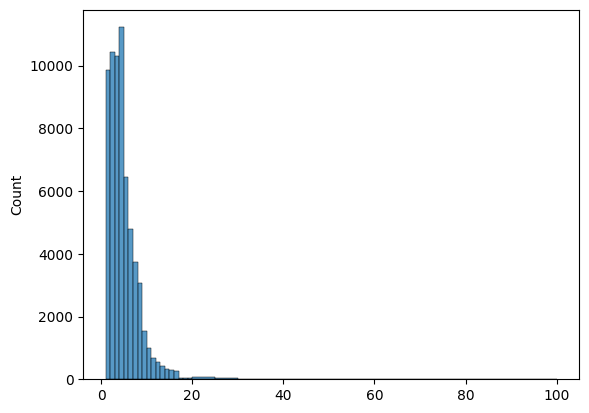

In [138]:
# check word length distribution
word_lengths = [len(word) for sent in train_sentences_origcase for word in sent]
sns.histplot(word_lengths, bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,40,50,100])
print(np.mean(word_lengths), np.median(word_lengths), np.percentile(word_lengths, 95))

In [139]:
#we set max_char for character encoding to be at 95 percentile value.
MAX_CHAR = 10
CHAR_EMBEDDING_SIZE = 20

## Load vocabulary and embeddings

### words vocabulary

In [140]:
import pickle

# helper function to download and cache gensim embeddings
def get_gensim_embeddings(name):

  embedding_path = f"{CONST['SAVED_EMBEDDINGS_PATH']}{name}.pickle"

  if os.path.exists(embedding_path):
    print(f'loading saved embeddings: {name}')
    try:
      with open(embedding_path, 'rb') as em:
        return pickle.load(em)
    except:
      print('error loading saved embeddings')

  print(f'downloading gensim embeddings: {name}')
  pretrained_embeddings = api.load(name)

  with open(embedding_path, 'wb') as em:
    pickle.dump(pretrained_embeddings, em, protocol=pickle.HIGHEST_PROTOCOL)

  return pretrained_embeddings

In [141]:
#create and adapt text vectorization layer

vectorize_layer, tokenizer = None, None

#flatten train_sentence to get all words
words_list = [word  for sentence in train_sentences for word in sentence]
words_list_origcase = [word  for sentence in train_sentences_origcase for word in sentence]

#word level vectorize/lookup layers

vectorize_layer = tf.keras.layers.TextVectorization(
    output_mode='int',
    standardize='lower',
    output_sequence_length=MAX_LEN)

#train on words
vectorize_layer.adapt(words_list)

word_vocab = vectorize_layer.get_vocabulary()[2:] #after removing '' and [UNK]

#string lookup layer
stringlookup_layer = tf.keras.layers.StringLookup(
    vocabulary=word_vocab,
    output_mode="int",
    pad_to_max_tokens=False,
)

#char level vectorize, lookup layers

#get all characters
chars_list_origcase = [ch for word in words_list_origcase for ch in word]

#create text vectorization layer for characters
char_vectorize_layer = tf.keras.layers.TextVectorization(
  output_mode='int',
  standardize=None,
  output_sequence_length=MAX_CHAR)

char_vectorize_layer.adapt(chars_list_origcase)

char_vocab = char_vectorize_layer.get_vocabulary()[2:]

#train on charcaters (case preserved)
char_stringlookup_layer = tf.keras.layers.StringLookup(
    vocabulary=char_vocab,
    output_mode="int",
    pad_to_max_tokens=False,
)

#Note: there is a difference of 1 (token '') between the vocabulary set by textvectorization and stringlookup layers.
#Thus depending on which layer we use in our model, we need to set embedding matrices accordingly
print(vectorize_layer.vocabulary_size(), stringlookup_layer.vocabulary_size())
print(char_vectorize_layer.vocabulary_size(), char_stringlookup_layer.vocabulary_size())

12975 12974
112 111


In [142]:
len(words_list), len(set(words_list)), vectorize_layer.vocabulary_size()

(65266, 12973, 12975)

### wordshape vocabulary

In [143]:
def handlespecialchar(c):
  if c in ["'",')','~','.',':','"','(','!',';','|','&','-','#','+',',','/','@']:
    return c
  else:
    return '*'

def wordshape(word):

  wshape = ['X' if c.isupper() else 'x' if c.islower() else 'd' if c.isdigit() else handlespecialchar(c) for c in word]
  wshape = [w for i, w in enumerate(wshape) if(i == 0 or wshape[i] != wshape[i-1])]
  return ''.join(wshape)

wordshape_list = [wordshape(w) for w in words_list_origcase]

#create text vectorization layer
wordshape_vectorizer = tf.keras.layers.TextVectorization(
  output_mode='int',
  standardize=None,
  max_tokens = DATA_PARAMS['wordshape_classes'])

#train on words
wordshape_vectorizer.adapt(wordshape_list)

### Load pre-trained embeddings

In [144]:

#load embedding matrix
def load_embeddings(embedding_name = 'glove-twitter-100' , embedding_dim = 100):

  vocab = None

  num_tokens = vectorize_layer.vocabulary_size()
  vocab = vectorize_layer.get_vocabulary()

  #load saved embeddings or download using gensim api
  pretrained_embeddings = get_gensim_embeddings(embedding_name)

  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens-1, embedding_dim))
  embedding_matrix2 = np.zeros((num_tokens, embedding_dim))

  for i, word in enumerate(vocab):
    embedding_vector = None
    try:
      embedding_vector = pretrained_embeddings[word]
    except Exception :
      pass

    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      if(i > 0):
        embedding_matrix[i-1] = embedding_vector
      embedding_matrix2[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  del pretrained_embeddings
  gc.collect()
  print("Converted %d words (%d misses)" % (hits, misses))

  #save downloaded embedding matrix..
  #np.save(embeddings_matrix_path, embedding_matrix)

  return embedding_matrix, embedding_matrix2

In [145]:
embedding_name, embedding_dim = DATA_PARAMS['embeddings']
embedding_matrix, embedding_matrix2 = load_embeddings(embedding_name = embedding_name, embedding_dim = embedding_dim)
print('embedding matrix shape: ', embedding_matrix.shape, embedding_matrix2.shape)

loading saved embeddings: glove-twitter-100
Converted 9020 words (3955 misses)
embedding matrix shape:  (12974, 100) (12975, 100)


## Rebalancing data

In [146]:
def drop_all_O_sentences(data, keep_rate=1.0):
  drop_rate = 1 - keep_rate

  #extract tags
  tags = [t for w,wog,t in data]

  #prepare mask for all_O sentences. True if it's an all_O sentence, False otherwise
  mask = pd.Series([len(s) == np.sum(np.array(s) == 'O') for s in tags])

  total_candidates = np.sum(mask)

  #select drop_rate percent of sentences to drop
  drop_candidates = mask[mask == True].sample(int(drop_rate * total_candidates)).index.values

  filtered_data = [item for i,item in enumerate(data) if i not in drop_candidates]

  print('data length: ', len(filtered_data))

  print(f'number of all-o sentences removed: {len(drop_candidates)}')

  return filtered_data

In [147]:
#remove all_O sentences
train_data = drop_all_O_sentences(train_data, keep_rate=DATA_PARAMS['all-o-keep-rate'])

data length:  2175
number of all-o sentences removed: 1626


In [148]:
#recompute data objects after cleaning and rebalancing data
train_sentences, train_sentences_origcase, train_tags = get_sentences_and_tags(train_data)
test_sentences, test_sentences_origcase, test_tags = get_sentences_and_tags(test_data)
dev_sentences, dev_sentences_origcase, dev_tags = get_sentences_and_tags(dev_data)

print(len(train_sentences), len(train_sentences_origcase))

print('\nTag count distribution for training dat after removing all_O sentences\n')
print(get_tags_count_df(train_tags))

2175 2175

Tag count distribution for training dat after removing all_O sentences

                freq    perc
O              35020  87.478
B-geo-loc        697   1.741
B-person         593   1.481
I-other          567   1.416
B-other          524   1.309
B-company        427   1.067
I-person         338   0.844
I-product        328   0.819
I-facility       264   0.659
B-facility       203   0.507
B-product        193   0.482
I-company        151   0.377
I-geo-loc        150   0.375
B-musicartist    134   0.335
I-musicartist    132   0.330
B-sportsteam     107   0.267
I-movie           51   0.127
B-movie           43   0.107
B-tvshow          41   0.102
I-tvshow          41   0.102
I-sportsteam      29   0.072


In [149]:
# rebalance tags

def oversample(sentences, tags, taglist, min_count=500):

  def get_cnt_of(sent, tag_name):
    return np.count_nonzero(sent == tag_name)

  #initialize tag to sentence index mapping
  tag_sentence_map = {t:[] for t in taglist}

  for i, s in enumerate(tags):
    tags_arr = pd.Series(s)
    vc = tags_arr.value_counts()
    for tag in vc.index:
      tag_sentence_map[tag].append((i, vc[tag]))


  #tag counts
  tag_counts = {}
  for t, arr in tag_sentence_map.items():
    tag_counts[t] = np.sum([pair[1] for pair in arr])

  ordered_tags = sorted(tag_counts.items(), key=lambda x: x[1])

  indices_to_add = []

  for tag, cnt in ordered_tags:
    #print('processing tag', tag)
    if(cnt > min_count):
      break

    while(True):
      deficit = min_count - tag_counts[tag]
      #print(f'decific for tag {tag} is {deficit}')
      if(deficit > 0):
        sent_indices = tag_sentence_map[tag]
        index1 = np.random.randint(low=0, high=len(sent_indices))
        index2, cnt2 = sent_indices[index1]

        indices_to_add.append(index2)

        #update count of all tags included in that sentence
        tags_arr = pd.Series(tags[index2])
        vc = tags_arr.value_counts()
        for t in vc.index:
          tag_counts[t] += vc[t]

      else:
        #print(f'breaking for {tag}, deficit is {deficit}')
        break

  return indices_to_add

In [150]:
indices_to_add = oversample(train_sentences, train_tags, list(train_tagset.keys()), min_count=DATA_PARAMS['oversample-min-cnt'])
print('indices to add', len(indices_to_add))
for i in indices_to_add:
  train_sentences.append(list(train_sentences[i]))
  train_sentences_origcase.append(list(train_sentences_origcase[i]))
  train_tags.append(list(train_tags[i]))

indices to add 5238


In [151]:
len(train_sentences), len(train_sentences_origcase), len(test_sentences), len(dev_sentences)

(7413, 7413, 1811, 1630)

In [152]:
get_tags_count_df(train_tags)

,freq,perc
O,113470,81.655
B-geo-loc,2556,1.839
B-person,1747,1.257
I-product,1584,1.140
B-company,1495,1.076
I-other,1454,1.046
B-other,1355,0.975
I-musicartist,1298,0.934
I-facility,1296,0.933
B-sportsteam,1224,0.881


## Data preparation

### Prepare input sequences


In [153]:
pad_sent = [''] * MAX_LEN
pad_word = [''] * MAX_CHAR

def get_model_inputs(sentences, sentences_origcase):

  '''
  expected word input: (batch, MAX_LEN)
  word input must be in lower case(since word embeddings are in lower case)
  '''
  word_input_lower = [np.array((sent + pad_sent)[:MAX_LEN]) for sent in sentences]

  '''
  expected char input: (None, MAX_LEN, MAX_CHAR)
  char input must be in original case since char level embeddings preserve case. We compute it in several steps as follow
  '''
  #step1: convert to list of list of padded words(case sensitive this time)
  word_input = [np.array((sent + pad_sent)[:MAX_LEN]) for sent in sentences_origcase]
  #step2: expand words into padded chars and create a flattened array
  char_input = [(list(word) + pad_word)[:MAX_CHAR] for sent in word_input for word in sent]
  #step3: reshape the array into [batch, MAX_LEN, MAX_CHAR]
  char_input = np.ravel(char_input).reshape(-1, MAX_LEN, MAX_CHAR)

  word_input_lower = tf.convert_to_tensor(word_input_lower)
  char_input = tf.convert_to_tensor(char_input)

  return word_input_lower, char_input

word_input_tr, char_input_tr = get_model_inputs(train_sentences, train_sentences_origcase)
word_input_dv, char_input_dv = get_model_inputs(dev_sentences, dev_sentences_origcase)
word_input_te, char_input_te = get_model_inputs(test_sentences, test_sentences_origcase)

### Prepare output sequences

In [154]:
#prepare tag classes so that 'O' is the first class, and rest of the classes appear in B-* and I-* pairs.
tags = list(train_tagset.keys())
tags.remove('O')
tags = sorted(tags, key=lambda x: x[::-1])
tags.insert(0, 'O')
tags

['O',
 'B-geo-loc',
 'I-geo-loc',
 'B-movie',
 'I-movie',
 'B-sportsteam',
 'I-sportsteam',
 'B-person',
 'I-person',
 'B-other',
 'I-other',
 'B-product',
 'I-product',
 'B-musicartist',
 'I-musicartist',
 'B-tvshow',
 'I-tvshow',
 'B-company',
 'I-company',
 'B-facility',
 'I-facility']

In [155]:
# unique tag classes
n_tags = len(tags)

#tag to index
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for i, t in enumerate(tags)}

#convert output tag sequences to int sequences
y_int_tr = [[tag2idx[t] for t in s] for s in train_tags]
y_int_te = [[tag2idx[t] for t in s] for s in test_tags]
y_int_dev = [[tag2idx[t] for t in s] for s in dev_tags]

pad_value = tag2idx["O"] if(DATA_PARAMS['use_tag_o_as_padding']) else -1

y_tr = pad_sequences(maxlen=MAX_LEN, sequences=y_int_tr, padding="post", value=pad_value)
y_te = pad_sequences(maxlen=MAX_LEN, sequences=y_int_te, padding="post", value=pad_value)
y_dev = pad_sequences(maxlen=MAX_LEN, sequences=y_int_dev, padding="post", value=pad_value)

# One-Hot encode such that for padded elements, ohe results in zero vector
y_tr = [to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in y_tr]
y_te = [to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in y_te]
y_dev = [to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in y_dev]

# Padding each sequence to have the same length
y_mask_tr = pad_sequences(maxlen=MAX_LEN, sequences=y_int_tr, padding="post", value=-1)
y_mask_te = pad_sequences(maxlen=MAX_LEN, sequences=y_int_te, padding="post", value=-1)
y_mask_dev = pad_sequences(maxlen=MAX_LEN, sequences=y_int_dev, padding="post", value=-1)

y_mask_tr = [to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in y_mask_tr]
y_mask_te = [to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in y_mask_te]
y_mask_dev = [to_categorical(i, num_classes=n_tags+1)[:,:-1] for i in y_mask_dev]

y_tr = np.array(y_tr)
y_te = np.array(y_te)
y_dev = np.array(y_dev)

y_mask_tr = np.array(y_mask_tr)
y_mask_te = np.array(y_mask_te)
y_mask_dev = np.array(y_mask_dev)

#view one example sequence
ex_in = 60

print('\n Raw Sample:\n ', ' '.join(train_sentences[ex_in]))
print('\n Raw Label:\n ', ' '.join(train_tags[ex_in]))
print('\n After processing, sample:\n', word_input_tr[ex_in])
print('\n After processing, labels:\n', y_tr[ex_in])


 Raw Sample:
  rt iowacityschools # there will be no classes for iowa city schools on monday # february 2nd # t.co

 Raw Label:
  O O O O O O O O O B-facility I-facility I-facility O O O O O O O

 After processing, sample:
 tf.Tensor(
[b'rt' b'iowacityschools' b'#' b'there' b'will' b'be' b'no' b'classes'
 b'for' b'iowa' b'city' b'schools' b'on' b'monday' b'#' b'february' b'2nd'
 b'#' b't.co' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b''], shape=(39,), dtype=string)

 After processing, labels:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1

In [156]:
#helper function
def get_unpad_ele_mask(y_true):
    return (np.sum(y_true, axis=-1) > 0).ravel()

## Custom Metrics

The training data consists of fixed size sequences with many padded tokens in each sentence. By default, keras compute metrics over all the elements of the sequence-including the padding elements. To rectify this, we create custom metrics which igore padded elements when computing metrics. Since out dataset is highly imbalanced, we also use balanced_accuracy as a reporting metric, in addition to using plain accuracy.

In [157]:
#simple metric which counts number of nonpadded elements seen so far (in each epoch)
class CustomTotal(tf.keras.metrics.Metric):
    def __init__(self, ignore_pad=True, name='custom_total', **kwargs):
        super(CustomTotal, self).__init__(name=name, **kwargs)

        self.ignore_pad = ignore_pad
        self.total = self.add_weight(name='total', initializer='zeros', dtype=np.int32)

    def update_state(self, y_true_ohe, y_pred_ohe, sample_weight=None):

        if(self.ignore_pad):
          nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0)
          total = tf.reduce_sum(tf.cast(nonpad_mask, tf.int32))
        else:
          total = tf.multiply(y_true_ohe.shape[0], y_true_ohe.shape[1])

        self.total.assign(self.total + total)

    def result(self):
        return self.total

    def reset_state(self):
        self.total.assign(0)

In [158]:
#mimicks accuracy metric, however ignores padded elements
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='acc', ignore_pad=True, **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)

        self.ignore_pad = ignore_pad

        self.true_positives = self.add_weight(name='tp', initializer='zeros', dtype=tf.int32)
        self.total = self.add_weight(name='total', initializer='zeros', dtype=tf.int32)

    def update_state(self, y_true_ohe, y_pred_ohe, sample_weight=None):

        y_true = tf.argmax(y_true_ohe, axis=-1, output_type=tf.int32)
        y_pred = tf.argmax(y_pred_ohe, axis=-1, output_type=tf.int32)

        if(self.ignore_pad):
          nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0)
          total = tf.reduce_sum(tf.cast(nonpad_mask, tf.int32))
          tp = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.equal(y_true, y_pred)), tf.int32))
        else:
          total = tf.multiply(y_true.shape[0], y_true.shape[1])
          tp = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.int32))

        self.true_positives.assign(self.true_positives + tp)
        self.total.assign(self.total + total)

    def result(self):
        return tf.math.divide_no_nan(self.true_positives, self.total)

    def reset_state(self):
        self.true_positives.assign(0)
        self.total.assign(0)


In [159]:
# computes balanced accuracy score after ignoring padded elements
class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_pad=True, name='bal_acc', **kwargs):
        super(BalancedAccuracy, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes
        self.ignore_pad = ignore_pad

        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true_ohe, y_pred_ohe, sample_weight=None):

        y_true = tf.argmax(y_true_ohe, axis=-1, output_type=tf.int32)
        y_pred = tf.argmax(y_pred_ohe, axis=-1, output_type=tf.int32)

        nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0)

        # Calculate true positives and false negatives for each class
        for i in range(self.num_classes):

            if(self.ignore_pad):
              tp = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i))), tf.float32))
              fn = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i))), tf.float32))
            else:
              tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
              fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i)), tf.float32))

            self.true_positives[i].assign(self.true_positives[i] + tp)
            self.false_negatives[i].assign(self.false_negatives[i] + fn)

    def result(self):

        sensitivity = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_negatives)
        balanced_accuracy = tf.reduce_mean(sensitivity)

        return balanced_accuracy

    def reset_state(self):
        self.true_positives.assign([0]*self.num_classes)
        self.false_negatives.assign([0]*self.num_classes)


In [160]:
from keras.backend import epsilon

# computes weighted-f1 BI score after ignoring padded elements
class WeightedF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, ignore_classes=[], ignore_pad=True, name='weighted_f1', **kwargs):
        super(WeightedF1, self).__init__(name=name, **kwargs)

        self.num_classes = num_classes
        self.ignore_classes = ignore_classes
        self.ignore_pad = ignore_pad

        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')
        self.total = self.add_weight(name='total', shape=(num_classes,), initializer='zeros')
        self.f1 = self.add_weight(name='f1', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true_ohe, y_pred_ohe, sample_weight=None):

        y_true = tf.argmax(y_true_ohe, axis=-1, output_type=tf.int32)
        y_pred = tf.argmax(y_pred_ohe, axis=-1, output_type=tf.int32)

        nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0)

        # Calculate tp,fp,fn,recall,precision,and f1 for each class
        for i in range(self.num_classes):

          if(i in self.ignore_classes):
            continue

          if(self.ignore_pad):
            tp = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i))), tf.float32))
            fn = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i))), tf.float32))
            fp = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.logical_and(tf.not_equal(y_true, i), tf.equal(y_pred, i))), tf.float32))
            total = tf.reduce_sum(tf.cast(tf.logical_and(nonpad_mask, tf.equal(y_true, i)), tf.float32))

          else:
            tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
            fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i)), tf.float32))
            fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, i), tf.equal(y_pred, i)), tf.float32))
            total = tf.reduce_sum(tf.cast(tf.equal(y_true, i), tf.float32))

          #compute class level f1 score
          actual_pos = tp + fn
          pred_pos = tp + fp

          precision = tp / (pred_pos + epsilon())
          recall = tp / (actual_pos + epsilon())

          f1_score = (2 * precision * recall) / (precision + recall + epsilon())

          #update overall state with the state from this batch
          self.f1[i].assign(f1_score)
          self.true_positives[i].assign(self.true_positives[i] + tp)
          self.false_negatives[i].assign(self.false_negatives[i] + fn)
          self.false_positives[i].assign(self.false_positives[i] + fp)
          self.total[i].assign(self.total[i] + total)

    def result(self):

        total_sum = tf.reduce_sum(self.total)
        weights = tf.math.divide_no_nan(self.total, total_sum)
        weighted_f1 = tf.reduce_sum(tf.multiply(self.f1, weights))

        return weighted_f1

    def reset_state(self):

        self.true_positives.assign([0]*self.num_classes)
        self.false_negatives.assign([0]*self.num_classes)
        self.false_positives.assign([0]*self.num_classes)
        self.total.assign([0]*self.num_classes)
        self.f1.assign([0]*self.num_classes)


In [161]:
from seqeval.metrics import f1_score as seq_eval_f1_score

#simple batch level wrapper over seqeval f1 score (runs eagerly)
@tf.py_function(Tout=tf.float32)
def seqeval_f1score(y_true_ohe, y_pred_ohe):

  nonpad_mask = tf.not_equal(tf.reduce_sum(y_true_ohe, axis=-1), 0).numpy().ravel()

  y_true = tf.argmax(y_true_ohe, axis=-1, output_type=tf.int32).numpy().ravel()
  y_pred = tf.argmax(y_pred_ohe, axis=-1, output_type=tf.int32).numpy().ravel()

  y_true = [idx2tag[tid] for tid in y_true[nonpad_mask]]
  y_pred = [idx2tag[tid] for tid in y_pred[nonpad_mask]]

  f1score = seq_eval_f1_score([y_true], [y_pred])

  return f1score


## Model training

In [162]:
#different class weights
alphas_dict = {}

y_actual = y_tr.argmax(axis=2)
mask = get_unpad_ele_mask(y_mask_tr)
train_labels_flattened = [idx2tag[ele] for ele in (y_actual.ravel())[mask]]

alphas_dict['sklearn-class-weighted'] = np.round(compute_class_weight(class_weight='balanced', classes=tags, y=train_labels_flattened), 2).tolist()

#custom weights 1
tags_count_df = get_tags_count_df(train_tags).loc[tags]

tags_count_df['weight'] =  tags_count_df.loc['O']['perc'] / tags_count_df['perc']
alphas_tmp = tags_count_df['weight'].values
print(np.round(alphas_tmp,1))

alphas_tmp[0] = 10
alphas_dict['custom1'] = np.round(alphas_tmp, 1).tolist()
alphas_dict['custom1_norm'] = np.round(alphas_dict['custom1'] / np.linalg.norm(alphas_dict['custom1']), 4)

#custom weights 2
alphas_tmp = np.ones((21)) * 80
alphas_tmp[0] = 10
alphas_dict['custom2'] = np.round(alphas_tmp, 2).tolist()

for k, v in alphas_dict.items():
  print(f'{k:<25}, {v}')

[  1.   44.4 107.7 112.2  96.2  92.7 113.4  65.  113.4  83.7  78.1 112.2
  71.6  98.6  87.4 111.9 111.4  75.9 109.2 113.3  87.5]
sklearn-class-weighted   , [0.06, 2.59, 6.28, 6.55, 5.61, 5.41, 6.61, 3.79, 6.62, 4.88, 4.55, 6.54, 4.18, 5.75, 5.1, 6.52, 6.5, 4.43, 6.36, 6.6, 5.11]
custom1                  , [10.0, 44.4, 107.7, 112.2, 96.2, 92.7, 113.4, 65.0, 113.4, 83.7, 78.1, 112.2, 71.6, 98.6, 87.4, 111.9, 111.4, 75.9, 109.2, 113.3, 87.5]
custom1_norm             , [0.0232 0.1031 0.2502 0.2606 0.2235 0.2153 0.2634 0.151  0.2634 0.1944
 0.1814 0.2606 0.1663 0.229  0.203  0.2599 0.2588 0.1763 0.2536 0.2632
 0.2032]
custom2                  , [10.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0]


In [163]:
alphas_key = 'custom1'

TRAIN_PARAMS = {
  'batch-size': 32,
  'epochs': 10,
  'validation-split' : 0.4,

  'lstm-units': 50,
  'dense-units': 100,
  'learning-rate': 0.01,
  'clipnorm': 1.0,
  'kernel-regularizer': [(0.0, 0.0), (0.0, 0.01), (0.0, 0.01)],
  'dropout-rate' : [0.0,0.0,0.0],

  'normalize-embeddings': True,
  'use_char_cnn': True,
  'wordshape_classes_flag': False,

  'gamma' : 3,
  'alphas-name': alphas_key,
  'alphas' : alphas_dict[alphas_key],
  'label-smoothing': 0.15,
}

TRAIN_PARAMS

{'batch-size': 32,
 'epochs': 10,
 'validation-split': 0.4,
 'lstm-units': 50,
 'dense-units': 100,
 'learning-rate': 0.01,
 'clipnorm': 1.0,
 'kernel-regularizer': [(0.0, 0.0), (0.0, 0.01), (0.0, 0.01)],
 'dropout-rate': [0.0, 0.0, 0.0],
 'normalize-embeddings': True,
 'use_char_cnn': True,
 'wordshape_classes_flag': False,
 'gamma': 3,
 'alphas-name': 'custom1',
 'alphas': [10.0,
  44.4,
  107.7,
  112.2,
  96.2,
  92.7,
  113.4,
  65.0,
  113.4,
  83.7,
  78.1,
  112.2,
  71.6,
  98.6,
  87.4,
  111.9,
  111.4,
  75.9,
  109.2,
  113.3,
  87.5],
 'label-smoothing': 0.15}

In [164]:
#define model input
train_sentences2 = [' '.join(sentence) for sentence in train_sentences]
word_input_str_tr = tf.convert_to_tensor(train_sentences2)

test_sentences2 = [' '.join(sentence) for sentence in test_sentences]
word_input_str_te = tf.convert_to_tensor(test_sentences2)

dev_sentences2 = [' '.join(sentence) for sentence in dev_sentences]
word_input_str_dv = tf.convert_to_tensor(dev_sentences2)

# X_tr = [word_input_tr, char_input_tr] if (TRAIN_PARAMS['use_char_cnn']) else word_input_tr
# X_te = [word_input_te, char_input_te] if (TRAIN_PARAMS['use_char_cnn']) else word_input_te
# X_dv = [word_input_dv, char_input_dv] if (TRAIN_PARAMS['use_char_cnn']) else word_input_dv

X_tr = [word_input_str_tr, char_input_tr] if (TRAIN_PARAMS['use_char_cnn']) else word_input_str_tr
X_te = [word_input_str_te, char_input_te] if (TRAIN_PARAMS['use_char_cnn']) else word_input_str_te
X_dv = [word_input_str_dv, char_input_dv] if (TRAIN_PARAMS['use_char_cnn']) else word_input_str_dv


In [165]:
from keras.models import Model
from keras.layers import Input
from keras.regularizers import L1L2

# LSTM components
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# CRF layer
from tensorflow_addons.layers import CRF

# focal cross entropy loss. works well with highly unbalanced input data
from keras.losses import CategoricalFocalCrossentropy
from keras.optimizers import AdamW


In [166]:
class WordShapeClassLayer(tf.keras.layers.Layer):

    def __init__(self, wordshape_vectorizer, words_per_sentence,  **kwargs):

        self.wordshape_vectorizer = wordshape_vectorizer
        self.words_per_sentence = words_per_sentence
        self.classes_count = wordshape_vectorizer.vocabulary_size()

        super(WordShapeClassLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(WordShapeClassLayer, self).build(input_shape)

    def call(self, sentences, **kwargs):

        self.is_symbolic_tensor = tf.is_symbolic_tensor(sentences)
        word_shapes_vectors = self.compute_word_shapes(sentences)
        return word_shapes_vectors

    # receives a batch of sentences (None,) with type tf.string and returns a batch of word shape vectors (None, 39, 20) with type tf.int32
    def compute_word_shapes(self, sentences):

        sentence_ragged = tf.strings.split(sentences)
        dense_sentences = sentence_ragged.to_tensor(shape=(sentences.shape[0], self.words_per_sentence))
        word_shapes = tf.map_fn(self.compute_word_shape, dense_sentences, fn_output_signature=tf.int32)

        return tf.cast(word_shapes, dtype=tf.float32)

    #input is (39,)
    def compute_word_shape(self, words):

        #allCaps, upperInitial, lowercase, mixedCaps, noinfo
        def wordshape(word):

          shape_class = 0
          if(not self.is_symbolic_tensor): #only during training/inference
            word = str(word.numpy(), 'utf8')

            #compute short word-shape
            wshape = ['X' if c.isupper() else 'x' if c.islower() else 'd' if c.isdigit() else c for c in word]
            wshape = ''.join([c for i, c in enumerate(wshape) if i == 0 or wshape[i] != wshape[i-1]])

            shape_class_arr = self.wordshape_vectorizer(wshape).numpy()
            if(shape_class_arr):
              shape_class = shape_class_arr[0]

          return shape_class

        #compute word shape classes
        wordshape_class_int = tf.map_fn(wordshape, words, fn_output_signature=tf.int32)
        wordshape_class_one_hot = tf.one_hot(wordshape_class_int, self.classes_count, dtype=tf.int32)

        return wordshape_class_one_hot #shape: (39, <classes_count>), tf.int32


In [167]:
class WordInfoClassLayer(tf.keras.layers.Layer):

    def __init__(self, words_per_sentence,  **kwargs):

        self.words_per_sentence = words_per_sentence
        super(WordInfoClassLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(WordInfoClassLayer, self).build(input_shape)

    def call(self, sentences, **kwargs):

        self.is_symbolic_tensor = tf.is_symbolic_tensor(sentences)
        return self.compute_word_info_vector(sentences)

    # receives a batch of sentences (None,) with type tf.string and returns a batch of word shape vectors (None, 39, 20) with type tf.int32
    def compute_word_info_vector(self, sentences):

        sentence_ragged = tf.strings.split(sentences)
        dense_sentences = sentence_ragged.to_tensor(shape=(sentences.shape[0], self.words_per_sentence))
        word_info_vector = tf.map_fn(self.compute_word_info, dense_sentences, fn_output_signature=tf.int32)

        return tf.cast(word_info_vector, dtype=tf.float32)

    #input is (39,)
    def compute_word_info(self, words):

        #allCaps, upperInitial, lowercase, mixedCaps, noinfo
        def wordinfo(word):

          info_class = 0
          if(not self.is_symbolic_tensor): #only during training/inference
            word = str(word.numpy(), 'utf8')

            #compute short word-shape
            wshape = ['X' if c.isupper() else 'x' if c.islower() else 'd' if c.isdigit() else c for c in word]
            wshape = ''.join([c for i, c in enumerate(wshape) if i == 0 or wshape[i] != wshape[i-1]])

            if(wshape == 'X'): #all caps
              info_class = 1
            elif(wshape == 'x'): #all lower
              info_class = 2
            elif(wshape == 'Xx'): #upper followed by lower
              info_class = 3
            elif(wshape.replace('X', '').replace('x', '') == ''): #mixed
              info_class = 4
            else:
              info_class = 0 #eg contains digits or special chars

          return info_class

        #compute word shape classes
        wordinfo_class_int = tf.map_fn(wordinfo, words, fn_output_signature=tf.int32)
        return tf.one_hot(wordinfo_class_int, 4, dtype=tf.int32)


In [168]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, LayerNormalization

def build_model2(max_len, max_char, char_embedding_size, embedding_matrix, num_classes, wordshape_vec=None, trainable=False, lr=0.01, normalize_embeddings=False, clipnorm=0.0, lstm_units=50, dense_units=100, kernel_reg = [(0.01, 0.01)]*3, dropout_rate = (0.2, 0.2, 0.2), gamma=10.0, alphas=None, label_smoothing=0.0, use_char_cnn=True):

  #Reference: https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/

  ''' word vectorizer(lookup) and embeddings
  '''

  #input is batch of sentences
  #word_input = Input(shape=(max_len), dtype=tf.string)
  word_input = Input(shape=(), dtype=tf.string)

  #vectorized_input is batch of padded list of ints (None, max_len)
  vectorized_input = vectorize_layer(word_input)
  #vectorized_input = stringlookup_layer(word_input)

  input_dim, embedding_dim = embedding_matrix.shape

  # pre-trained word embeddings (None, max_len, embedding_dim)
  word_embeddings = Embedding(input_dim=input_dim,
                      output_dim=embedding_dim,
                      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                      input_length=max_len, mask_zero=True, trainable=trainable
                    )(vectorized_input)

  if(normalize_embeddings):
    word_embeddings = LayerNormalization()(word_embeddings)

  concatenation_arr = [word_embeddings]

  ''' word info vector
  '''
  info_vector = WordInfoClassLayer(max_len)(word_input)
  concatenation_arr.append(info_vector)

  ''' char vectorizer(lookup) and embeddings
  '''

  #char_input - (None, max_len, max_char)
  char_input = Input(shape=(max_len, max_char), dtype=tf.string)

  # char_vectorized_input - (None. max_len, max_char)
  char_vectorized_input = TimeDistributed(char_stringlookup_layer)(char_input)

  # character level embeddings (None, max_len, max_char, embedding_dim)
  char_embeddings = Embedding(input_dim=char_vectorize_layer.vocabulary_size(),
                      output_dim=char_embedding_size,
                      input_length=max_char, mask_zero=True, trainable=True,
                      embeddings_initializer = tf.keras.initializers.GlorotNormal(seed=123)
                    )(char_vectorized_input)

  if(normalize_embeddings):
    char_embeddings = LayerNormalization()(char_embeddings)

  char_cnn = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(char_embeddings)  # None, MAX_LEN, MAX_CHAR, 16
  char_cnn = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(char_cnn)         # None, MAX_LEN, MAX_CHAR, 16
  char_cnn = TimeDistributed(MaxPooling1D())(char_cnn)                                              # None, MAX_LEN, MAX_CHAR/2, 16
  char_cnn = Conv1D(filters=20, kernel_size=3, padding='same', activation='relu')(char_cnn)         # None, MAX_LEN, MAX_CHAR/2, 20
  char_cnn = Conv1D(filters=20, kernel_size=3, padding='same', activation='relu')(char_cnn)         # None, MAX_LEN, MAX_CHAR/2, 20
  char_max_pool = TimeDistributed(GlobalMaxPooling1D())(char_cnn)                                   # None, MAX_LEN, 20

  if(use_char_cnn):
    model_input = [word_input, char_input]
    concatenation_arr.append(char_max_pool)
  else:
    model_input = word_input

  concatenated_embeddings = tf.keras.layers.Concatenate(axis=-1)(concatenation_arr)

  bidirection_output = Bidirectional(LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=kernel_reg[0][0], l2=kernel_reg[0][1])))(concatenated_embeddings)
  bidirection_output = Dropout(dropout_rate[0])(bidirection_output)

  bidirection_output = Bidirectional(LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=kernel_reg[1][0], l2=kernel_reg[1][1])))(bidirection_output)
  bidirection_output = Dropout(dropout_rate[1])(bidirection_output)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(dense_units, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=kernel_reg[2][0], l2=kernel_reg[2][1])))(bidirection_output)
  dense_out = Dropout(dropout_rate[2])(dense_out)

  # CRF layer
  crf = CRF(21, name='crf')
  decoded_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(model_input, potentials)
  viterbi_model = Model(model_input, decoded_sequence)

  optimizer = AdamW(learning_rate=lr, clipnorm=clipnorm)
  loss = CategoricalFocalCrossentropy(from_logits=True, gamma = gamma, alpha = alphas, label_smoothing=label_smoothing)

  model.compile(optimizer=optimizer, loss=loss, metrics=[
      CustomAccuracy(ignore_pad=True),
      BalancedAccuracy(num_classes, ignore_pad=True),
      WeightedF1(num_classes, ignore_classes=[0], ignore_pad=True),
      seqeval_f1score])

  return model, viterbi_model



In [169]:
model, viterbi_model = build_model2(MAX_LEN,
                                   MAX_CHAR, #max_char
                                   CHAR_EMBEDDING_SIZE, #char_embed_size
                                   embedding_matrix2,
                                   num_classes = n_tags,
                                   use_char_cnn = TRAIN_PARAMS['use_char_cnn'],
                                   trainable=False,
                                   normalize_embeddings = TRAIN_PARAMS['normalize-embeddings'],
                                   lr=TRAIN_PARAMS['learning-rate'],
                                   clipnorm=TRAIN_PARAMS['clipnorm'],
                                   lstm_units = TRAIN_PARAMS['lstm-units'],
                                   dense_units = TRAIN_PARAMS['dense-units'],
                                   kernel_reg = TRAIN_PARAMS['kernel-regularizer'],
                                   dropout_rate = TRAIN_PARAMS['dropout-rate'],
                                   alphas=TRAIN_PARAMS['alphas'],
                                   gamma=TRAIN_PARAMS['gamma'],
                                   label_smoothing=TRAIN_PARAMS['label-smoothing'])


checkpoint_path = f"{CONST['MODEL_CHECKPOINT_FILE_PATH']}twitter_ner_crf"

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
  #monitor='val_loss',
  monitor='val_seqeval_f1score',
  #monitor='val_weighted_f1',
  #monitor='val_bal_acc',
  mode='max',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

callbacks = [save_model, es, reduce_lr]

model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 39, 10)]             0         []                            
                                                                                                  
 time_distributed_12 (TimeD  (None, 39, 10)               0         ['input_9[0][0]']             
 istributed)                                                                                      
                                                                                                  
 embedding_8 (Embedding)     (None, 39, 10, 20)           2240      ['time_distributed_12[0][0]'] 
                                                                                                  
 layer_normalization_8 (Lay  (None, 39, 10, 20)           40        ['embedding_8[0][0]']   

In [170]:
set_seeds(201)

history = model.fit(X_tr,
                    y_tr,
                    validation_data = (X_dv, y_dev),
                    #validation_split=0.3,
                    shuffle = True,
                    batch_size=TRAIN_PARAMS['batch-size'],
                    epochs=TRAIN_PARAMS['epochs'],
                    callbacks = callbacks)

model.load_weights(checkpoint_path)

Epoch 1/10


232/232 [==============================] - ETA: 0s - loss: 52.1378 - acc: 0.9429 - bal_acc: 0.6810 - weighted_f1: 0.8208 - seqeval_f1score: 0.4678
Epoch 1: val_seqeval_f1score improved from -inf to 0.28413, saving model to /content/checkpoints/twitter_ner_crf
232/232 [==============================] - 105s 312ms/step - loss: 52.1378 - acc: 0.9429 - bal_acc: 0.6810 - weighted_f1: 0.8208 - seqeval_f1score: 0.4678 - val_loss: 49.1370 - val_acc: 0.9630 - val_bal_acc: 0.3522 - val_weighted_f1: 0.2216 - val_seqeval_f1score: 0.2841 - lr: 0.0100
Epoch 2/10
232/232 [==============================] - ETA: 0s - loss: 46.6762 - acc: 0.9809 - bal_acc: 0.9349 - weighted_f1: 0.7153 - seqeval_f1score: 0.7789
Epoch 2: val_seqeval_f1score improved from 0.28413 to 0.29794, saving model to /content/checkpoints/twitter_ner_crf
232/232 [==============================] - 57s 244ms/step - loss: 46.6762 - acc: 0.9809 - bal_acc: 0.9349 - weighted_f1: 0.7153 - seqeval_f1score: 0.7789 - val_loss: 48.5296 - val_ac

In [171]:
#model.save_weights(CONST['SAVED_MODEL'])

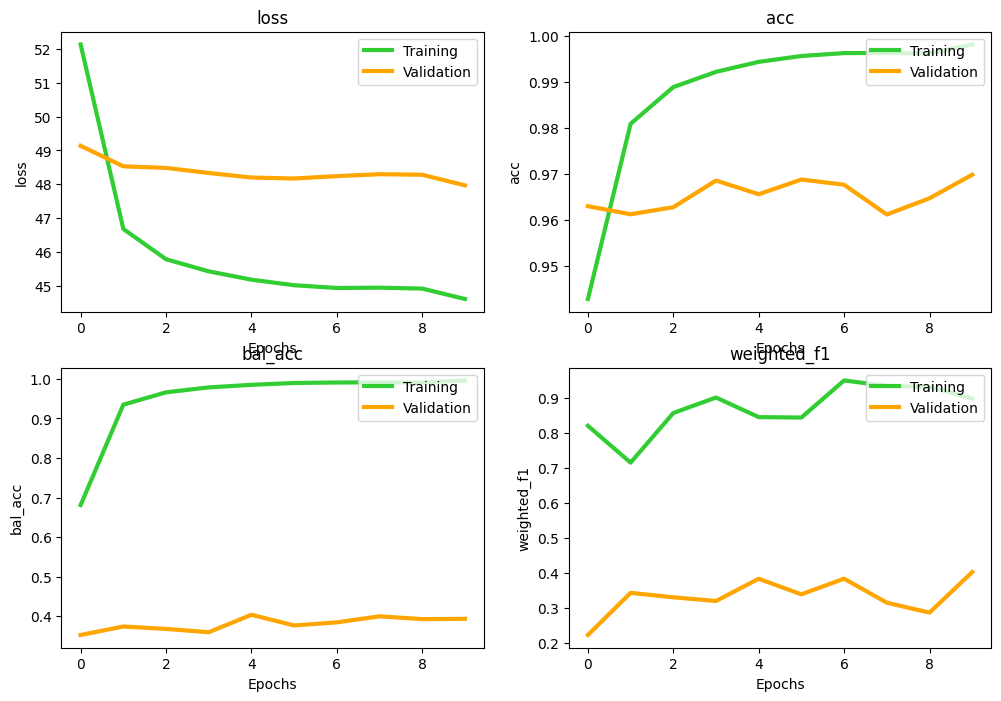

In [172]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for metric, ax in zip(['loss', 'acc', 'bal_acc', 'weighted_f1'], [axes[0,0], axes[0,1], axes[1,0], axes[1,1]]):

  ax.plot(history.history[metric],linewidth=3,color='limegreen')
  ax.plot(history.history[f'val_{metric}'],linewidth=3,color='orange')
  ax.set_title(metric)
  ax.set_xlabel('Epochs')
  ax.set_ylabel(metric)
  ax.legend()
  ax.legend(["Training", "Validation"], loc ="upper right")


## Model Prediction

In [173]:
def id2tag(y):
  return np.array([[idx2tag[w] for w in s] for s in y])

# correct I-X to B-X if they occur as the first tag
def rectify_output_tags(y_pred):
  cnt = 0
  for s in y_pred:
    for i in range(len(s)):
      if(s[i].startswith('I')):
        if(i == 0 or s[i-1][1:] != s[i][1:]): #tags different from prev tag
          s[i] = 'B' + s[i][1:]
          cnt += 1
  print(cnt, ' tags corrected')
  return np.array(y_pred)

# -- predict on the test data --

y_actual_id_te = y_te.argmax(axis=2) #actual y
y_pred_id_te = model.predict(X_te).argmax(axis=2) #marginal output by taking argmax over potentials
y_decoded_id_te = viterbi_model.predict(X_te) #viterbi decoding output

# -- predict on the training data --

y_actual_id_tr = y_tr.argmax(axis=2) #actual y
y_pred_id_tr = model.predict(X_tr).argmax(axis=2) #marginal output by taking argmax over potentials
y_decoded_id_tr = viterbi_model.predict(X_tr) #viterbi decoding output

# -- predict on the dev data --
y_actual_id_dev = y_dev.argmax(axis=2) #actual y
y_pred_id_dev = model.predict(X_dv).argmax(axis=2) #marginal output by taking argmax over potentials
y_decoded_id_dev = viterbi_model.predict(X_dv) #viterbi decoding output

#convert from int to tags
y_actual_te, y_pred_te, y_decoded_te = [id2tag(y_val) for y_val in [y_actual_id_te, y_pred_id_te, y_decoded_id_te]]
y_actual_tr, y_pred_tr, y_decoded_tr = [id2tag(y_val_tr) for y_val_tr in [y_actual_id_tr, y_pred_id_tr, y_decoded_id_tr]]
y_actual_dev, y_pred_dev, y_decoded_dev = [id2tag(y_val_dev) for y_val_dev in [y_actual_id_dev, y_pred_id_dev, y_decoded_id_dev]]

#rectify output tags
#y_pred, y_decoded = [rectify_output_tags(y_val) for y_val in [y_pred, y_decoded]]
#y_pred_tr, y_decoded_tr = [rectify_output_tags(y_val_tr) for y_val_tr in [y_pred_tr, y_decoded_tr]]

51/51 [==============================] - 4s 73ms/step


## Model Evaluation

### Helper functions

In [179]:
# Helper function to flatten actual and decoded sequences after unpadding them
def unpad_and_flatten_outputs(y_actual_ohe, y_actual, y_pred):
  # y_actual has all zeros at positions which were padded. We need to return the actual and predicted flattened arrays
  # after ignoring outputs at padded positions.

  mask = get_unpad_ele_mask(y_actual_ohe)


  actual_labels = y_actual.ravel()[mask]
  pred_labels = y_pred.ravel()[mask]

  return np.array(actual_labels), np.array(pred_labels)

y_actual_te_flattened, y_decoded_te_flattened = unpad_and_flatten_outputs(y_mask_te, y_actual_te, y_decoded_te)
y_actual_te_flattened, y_pred_te_flattened = unpad_and_flatten_outputs(y_mask_te, y_actual_te, y_pred_te)

y_actual_tr_flattened, y_decoded_tr_flattened = unpad_and_flatten_outputs(y_mask_tr, y_actual_tr, y_decoded_tr)
y_actual_tr_flattened, y_pred_tr_flattened = unpad_and_flatten_outputs(y_mask_tr, y_actual_tr, y_pred_tr)

y_actual_dev_flattened, y_decoded_dev_flattened = unpad_and_flatten_outputs(y_mask_dev, y_actual_dev, y_decoded_dev)
y_actual_dev_flattened, y_pred_dev_flattened = unpad_and_flatten_outputs(y_mask_dev, y_actual_dev, y_pred_dev)

In [175]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix

def plot_confusion_matrix(y_actual, y_pred):

  accuracy = np.sum(np.array(y_actual) == np.array(y_pred)) / len(y_actual)
  print(f'Accuracy: {accuracy}')

  cm = confusion_matrix(y_actual, y_pred, labels=tags)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags)
  disp.plot()
  fig = disp.figure_
  fig.set_figwidth(15)
  fig.set_figheight(8)
  fig.suptitle('Plot of confusion matrix')
  disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=90, ha='right')
  plt.show()


In [176]:
from seqeval.metrics import f1_score as seq_eval_f1_score

def evaluation_scores(y_actual, y_pred, tags):
  BI_tags = np.array(tags)
  BI_tags = list(BI_tags[BI_tags != 'O']) #without O tag

  class_scores = []
  zer_div = 0
  rounding_scale = 2

  mcm = multilabel_confusion_matrix(y_actual, y_pred, labels=tags)
  seqeval_f1 = seq_eval_f1_score([list(y_actual)], [list(y_pred)])

  for i in range(mcm.shape[0]):
    cm = mcm[i]
    TN, TP = cm[0][0], cm[1][1]
    FN, FP = cm[1][0], cm[0][1]
    P = TP + FN #actual positives
    N = TN + FP #actual negatives
    PP = TP + FP #predicted positives
    PN = TN + FN #predicted negatives

    #accuracy = np.round((TP + TN) / (P + N), rounding_scale)
    precision = np.round(TP / PP, rounding_scale) if (PP > 0) else 0
    recall = np.round(TP / P, rounding_scale)
    f1 = np.round(2*precision*recall / (precision + recall), rounding_scale) if ((precision + recall) > 0) else 0

    class_scores.append([tags[i], np.round(P), np.round(TP), np.round(FP), np.round(FN), precision, recall, f1])


  overall_scores = []

  overall_scores.append(['-', 'accuracy', 'all (BIO)', np.round(accuracy_score(y_actual, y_pred), rounding_scale)])
  overall_scores.append(['-', 'bal-acc (macro recall)', 'all (BIO)', np.round(recall_score(y_actual, y_pred, average='macro', labels=tags), rounding_scale)])
  overall_scores.append(['-', 'seqeval f1_score', 'all (BIO)', np.round(seqeval_f1, rounding_scale)])

  for metric, fn in [('precision', precision_score), ('recall', recall_score), ('f1', f1_score)]:
    overall_scores.append(['weighted', metric, 'all (BIO)', np.round(fn(y_actual, y_pred, average='weighted',  labels=tags, zero_division=zer_div), rounding_scale )])

  for metric, fn in [('precision', precision_score), ('recall', recall_score), ('f1', f1_score)]:
    overall_scores.append(['weighted', metric, 'only BI', np.round(fn(y_actual, y_pred, average='weighted',  labels=BI_tags, zero_division=zer_div), rounding_scale)])

  class_scores_df = pd.DataFrame(data=class_scores, columns=['tag', 'actual', 'TP', 'FP', 'FN', 'precision', 'recall', 'f1']).set_index('tag')
  overall_scores_df = pd.DataFrame(data = overall_scores, columns = ['average', 'metric', 'tags', 'score']).set_index(['average', 'metric', 'tags'])

  return class_scores_df, overall_scores_df


### High level evaluation

In [180]:
#train
viterbi_class_scores_df_tr, viterbi_overall_scores_df_tr = evaluation_scores(y_actual_tr_flattened, y_decoded_tr_flattened, tags)
potentials_class_scores_df_tr, potentials_overall_scores_df_tr = evaluation_scores(y_actual_tr_flattened, y_pred_tr_flattened, tags)

#test
viterbi_class_scores_df_te, viterbi_overall_scores_df_te = evaluation_scores(y_actual_te_flattened, y_decoded_te_flattened, tags)
potentials_class_scores_df_te, potentials_overall_scores_df_te = evaluation_scores(y_actual_te_flattened, y_pred_te_flattened, tags)

#dev
viterbi_class_scores_df_dev, viterbi_overall_scores_df_dev = evaluation_scores(y_actual_dev_flattened, y_decoded_dev_flattened, tags)
potentials_class_scores_df_dev, potentials_overall_scores_df_dev = evaluation_scores(y_actual_dev_flattened, y_pred_dev_flattened, tags)


In [181]:
summarydf = pd.concat([viterbi_overall_scores_df_tr, potentials_overall_scores_df_tr, viterbi_overall_scores_df_dev, potentials_overall_scores_df_dev, viterbi_overall_scores_df_te, potentials_overall_scores_df_te], axis=1)
summarydf.columns = ['tr_viterbi', 'tr_potential', 'dev_viterbi', 'dev_potential', 'te_viterbi', 'te_potential']

summarydf

tr_viterbi  tr_potential  \
average  metric                 tags                                  
-        accuracy               all (BIO)        1.00          1.00   
         bal-acc (macro recall) all (BIO)        1.00          1.00   
         seqeval f1_score       all (BIO)        0.99          0.99   
weighted precision              all (BIO)        1.00          1.00   
         recall                 all (BIO)        1.00          1.00   
         f1                     all (BIO)        1.00          1.00   
         precision              only BI          0.99          0.99   
         recall                 only BI          1.00          1.00   
         f1                     only BI          0.99          0.99   

                                           dev_viterbi  dev_potential  \
average  metric                 tags                                    
-        accuracy               all (BIO)         0.93           0.93   
         bal-acc (macro recall) all (BIO)         0.39           0.39   
         seqeval f1_score       all (BIO)         0.38           0.39   
weighted precision              all (BIO)         0.94           0.94   
         recall                 all (BIO)         0.93           0.93   
         f1                     all (BIO)         0.93           0.93   
         precision              only BI           0.47           0.47   
         recall                 only BI           0.44           0.45   
         f1                     only BI           0.44           0.44   

                                           te_viterbi  te_potential  
average  metric                 tags                                 
-        accuracy               all (BIO)        0.93          0.93  
         bal-acc (macro recall) all (BIO)        0.41          0.43  
         seqeval f1_score       all (BIO)        0.39          0.41  
weighted precision              all (BIO)        0.94          0.94  
         recall                 all (BIO)        0.93          0.93  
         f1                     all (BIO)        0.94          0.94  
         precision              only BI          0.50          0.50  
         recall                 only BI          0.47          0.48  
         f1                     only BI          0.47          0.47

### Train set - Viterbi decoded sequence

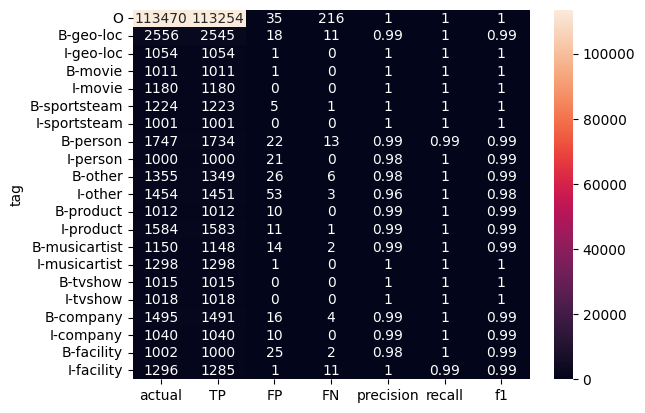

In [182]:
# viterbi decoded sequence performance on train set
ax = sns.heatmap(viterbi_class_scores_df_tr, annot=True, fmt='g')

### Train set - predicted sequence with argmax (non-viterbi)

<Axes: ylabel='tag'>

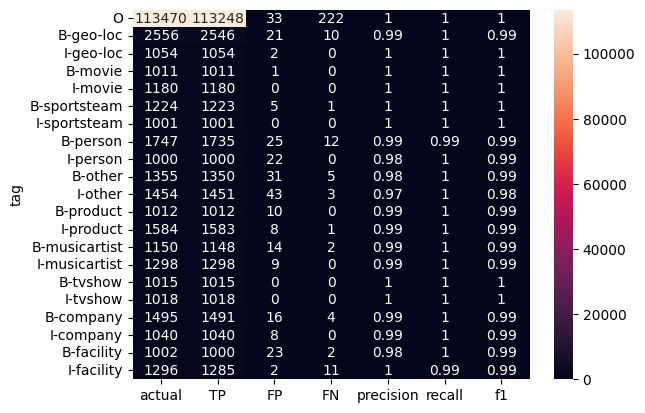

In [183]:
sns.heatmap(potentials_class_scores_df_tr, annot=True, fmt='g')

### Test set - Viterbi decoded sequence

Accuracy: 0.9344833145252297


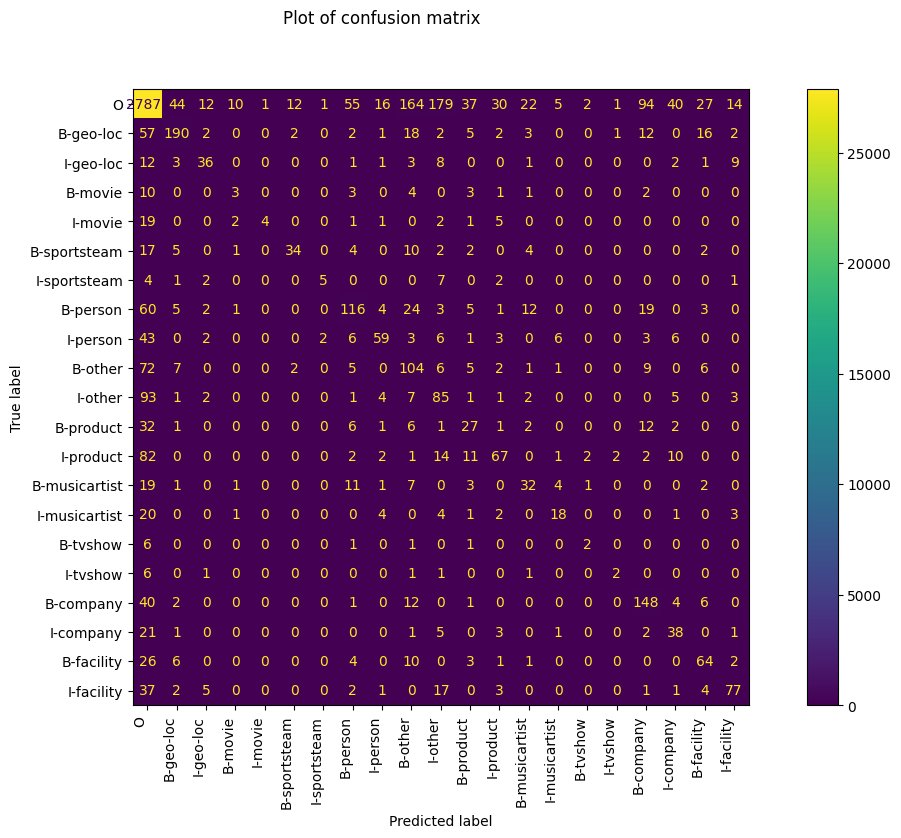

In [184]:
plot_confusion_matrix(y_actual_te_flattened, y_decoded_te_flattened)

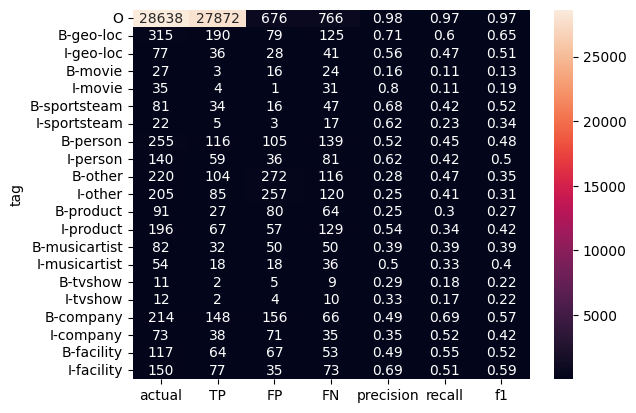

In [185]:
# viterbi decoded sequence performance on test set
viterbi_class_scores_df_te, viterbi_overall_scores_df_te = evaluation_scores(y_actual_te_flattened, y_decoded_te_flattened, tags)
ax = sns.heatmap(viterbi_class_scores_df_te, annot=True, fmt='g')

### Test set - predicted sequence with argmax (non-viterbi)

Accuracy: 0.9349347090117685


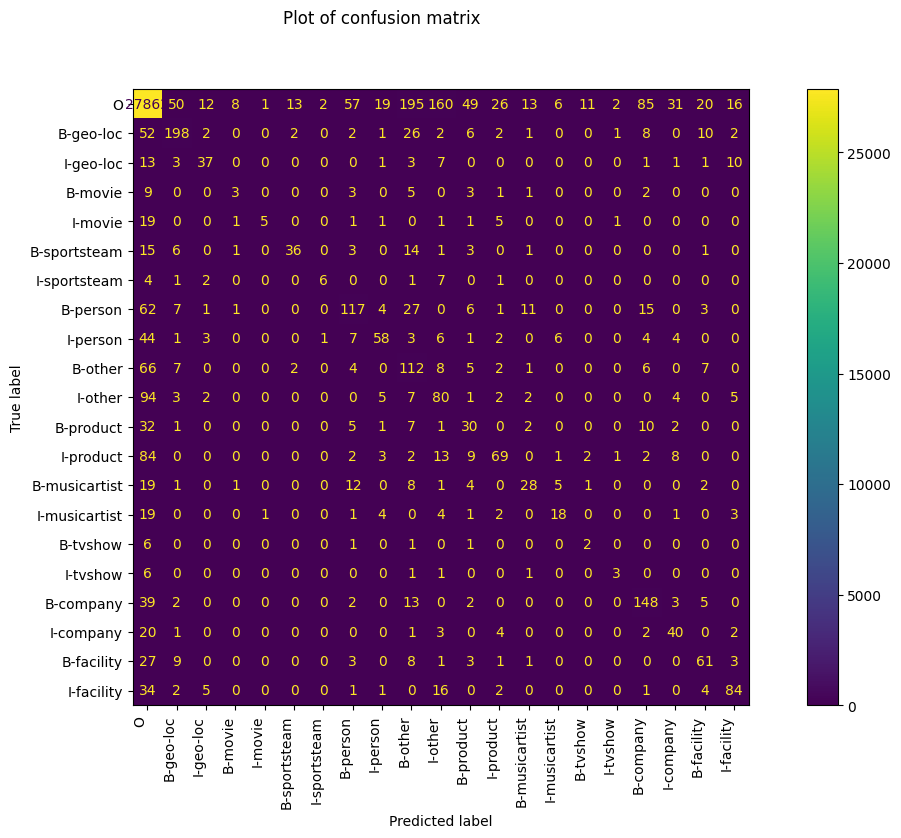

In [186]:
plot_confusion_matrix(y_actual_te_flattened, y_pred_te_flattened)

<Axes: ylabel='tag'>

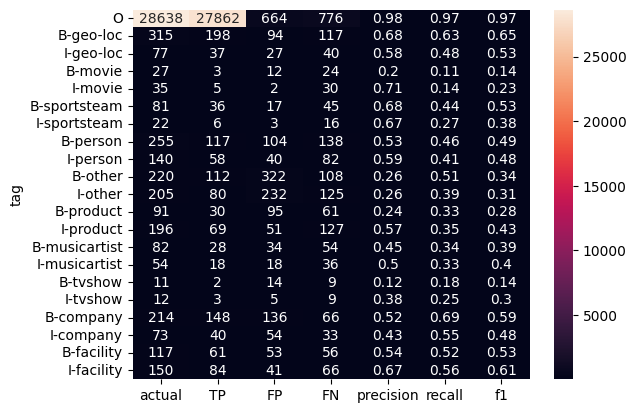

In [187]:
potentials_class_scores_df_te, potentials_overall_scores_df_te = evaluation_scores(y_actual_te_flattened, y_pred_te_flattened, tags)
sns.heatmap(potentials_class_scores_df_te, annot=True, fmt='g')

## mlflow logging

In [188]:
# #start mlflow experiement
# mlflow.set_experiment(experiment_id = crf_exp_id)
# try:
#   mlflow.start_run(experiment_id=crf_exp_id)
# except: pass
# mlfl = mlflow_logger(mlflow)

In [189]:
# #log data and train params
# mlfl.log_obj(DATA_PARAMS)
# mlfl.log_obj(TRAIN_PARAMS)

# #log training and validation metrics
# mlfl.log_metric('loss', history.history['loss'][-1])
# mlfl.log_metric('val_loss', history.history['val_loss'][-1])

# #log classification metrics
# potential_acc = potentials_overall_scores_df_te.loc[('-', 'accuracy', 'all (BIO)')][0]
# potential_f1 = potentials_overall_scores_df_te.loc[('weighted', 'f1', 'all (BIO)')][0]
# potential_f1_without_o = potentials_overall_scores_df_te.loc[('weighted', 'f1', 'only BI')][0]

# mlfl.log_metric('potential-acc', potential_acc)
# mlfl.log_metric('potential-f1', potential_f1)
# mlfl.log_metric('potential-f1-without-o', potential_f1_without_o)

# viterbi_acc = viterbi_overall_scores_df_te.loc[('-', 'accuracy', 'all (BIO)')][0]
# viterbi_f1 = viterbi_overall_scores_df_te.loc[('weighted', 'f1', 'all (BIO)')][0]
# viterbi_f1_without_o = viterbi_overall_scores_df_te.loc[('weighted', 'f1', 'only BI')][0]

# mlfl.log_metric('viterbi-acc', viterbi_acc)
# mlfl.log_metric('viterbi-f1', viterbi_f1)
# mlfl.log_metric('viterbi-f1-without-o', viterbi_f1_without_o)

# mlfl.log_metric('acc', max(viterbi_acc, potential_acc))
# mlfl.log_metric('f1', max(viterbi_f1, potential_f1))
# mlfl.log_metric('f1-without-o', max(viterbi_f1_without_o, potential_f1_without_o))

In [190]:
# #end the experiment
# mlflow.end_run()

In [191]:
# #view experiments so far
# results = mlflow.search_runs(experiment_ids=crf_exp_id)

# cols_to_ignore = ['params.alphas']
# results = results.drop(columns=cols_to_ignore)
# param_cols = results.columns[results.columns.str.startswith('metric') | results.columns.str.startswith('param')]
# results[param_cols].sort_values(by='metrics.f1-without-o', ascending=False).head(10).T

## Notification sound

In [192]:
from IPython.display import Audio
wave = np.sin(2*np.pi*200*np.arange(1000*1)/10000)
Audio(wave, rate=10000, autoplay=True)